In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
img_h_w = 224
data_transforms = {
    'train': v2.Compose([
        v2.ToImage(),
        v2.RandomRotation(20),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.Resize(img_h_w, antialias=True),
        # v2.ColorJitter(0.5, 0.5, 0.5, 0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.ToDtype(torch.float32, scale=True),
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.Resize(img_h_w, antialias=True),
        v2.ToDtype(torch.float32, scale=True),
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True , num_workers=2)
               for x in ['train', 'val']}
# dataloaders = {"val": torch.utils.data.DataLoader(image_datasets["val"], batch_size=4, shuffle=False), "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=16, shuffle=True, num_workers=2)}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

colors_per_class = {
        0 : [254, 202, 87],
        1 : [255, 107, 107],
        2 : [10, 189, 227],
        3 : [255, 159, 243],
        4 : [16, 172, 132],
        5 : [128, 80, 128],
        6 : [255, 165, 0],
        7 : [0, 128, 0],
        8 : [0, 0, 128],
        9 : [128, 0, 0],
    }

## With pretrained Resnet 34

In [4]:
model_ft = models.resnet34(weights='IMAGENET1K_V1')

# model_ft.load_state_dict(torch.load("ckpts/model_wbc_resnet34.pth"))


num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_ft.avgpool.register_forward_hook(get_activation('avgpool'))

In [5]:
import tqdm
labels = []
outputs = torch.zeros((0,512))
ii = np.zeros((0,3,img_h_w,img_h_w))
for (inputs, label) in tqdm.tqdm(dataloaders['val'], desc='Running the model inference'):
    images = inputs.to(device)
    labels += list(label.numpy())
 
    output = model_ft.forward(images)
 
    current_outputs = activation['avgpool'].squeeze((2,3)).cpu().numpy()
    outputs = np.concatenate((outputs, current_outputs))
    ii = np.concatenate((ii, inputs))

Running the model inference: 100%|██████████| 72/72 [00:10<00:00,  7.01it/s]


In [6]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=10000)

In [7]:
%%time
X_2d = tsne.fit_transform(outputs)

CPU times: user 4min 39s, sys: 30.4 ms, total: 4min 39s
Wall time: 11.8 s


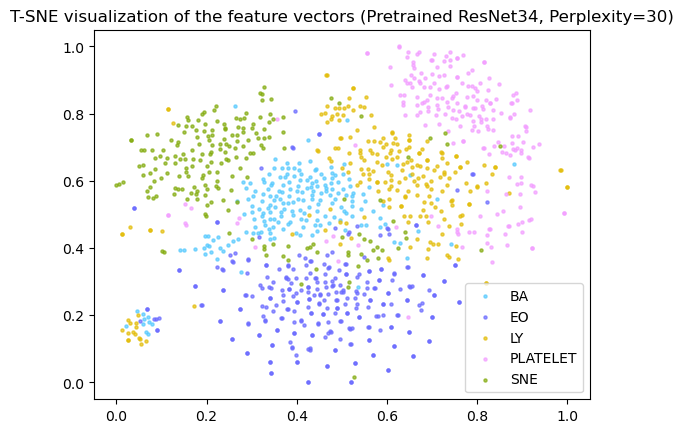

In [8]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = X_2d[:, 0]
ty = X_2d[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
 
# for every class, we'll add a scatter plot separately
for label in np.unique(labels):
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    # color = colors_per_class[label]
    color = np.array([colors_per_class[label][::-1]], dtype=np.float16) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=class_names[label], alpha=0.7, s=5)
    ax.title.set_text('T-SNE visualization of the feature vectors (Pretrained ResNet34, Perplexity=30)')
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=10000)

In [10]:
%%time
X_2d = tsne.fit_transform(outputs)

CPU times: user 4min 31s, sys: 28.3 ms, total: 4min 31s
Wall time: 11.3 s


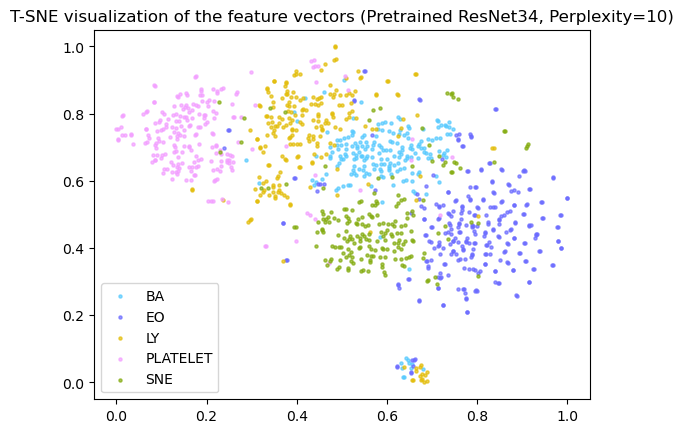

In [11]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = X_2d[:, 0]
ty = X_2d[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
 
# for every class, we'll add a scatter plot separately
for label in np.unique(labels):
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    # color = colors_per_class[label]
    color = np.array([colors_per_class[label][::-1]], dtype=np.float16) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=class_names[label], alpha=0.7, s=5)
    ax.title.set_text('T-SNE visualization of the feature vectors (Pretrained ResNet34, Perplexity=10)')
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot

## With finetuned Resnet 34

In [12]:
model_ft = models.resnet34(weights='IMAGENET1K_V1')




num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load("ckpts/model_wbc_resnet34.pth"))
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_ft.avgpool.register_forward_hook(get_activation('avgpool'))

In [13]:
import tqdm
labels = []
outputs = torch.zeros((0,512))
ii = np.zeros((0,3,img_h_w,img_h_w))
for (inputs, label) in tqdm.tqdm(dataloaders['val'], desc='Running the model inference'):
    images = inputs.to(device)
    labels += list(label.numpy())
 
    output = model_ft.forward(images)
 
    current_outputs = activation['avgpool'].squeeze((2,3)).cpu().numpy()
    outputs = np.concatenate((outputs, current_outputs))
    ii = np.concatenate((ii, inputs))

Running the model inference: 100%|██████████| 72/72 [00:09<00:00,  7.86it/s]


In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=10000)

In [15]:
%%time
X_2d = tsne.fit_transform(outputs)

CPU times: user 5min 33s, sys: 2.13 s, total: 5min 35s
Wall time: 14 s


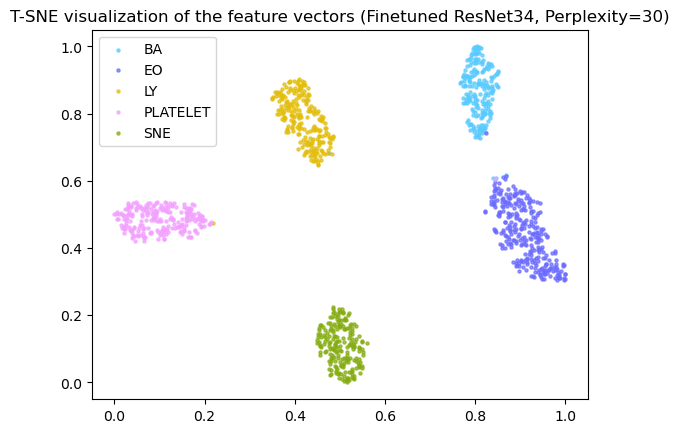

In [16]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = X_2d[:, 0]
ty = X_2d[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
 
# for every class, we'll add a scatter plot separately
for label in np.unique(labels):
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    # color = colors_per_class[label]
    color = np.array([colors_per_class[label][::-1]], dtype=np.float16) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=class_names[label], alpha=0.7, s=5)
    ax.title.set_text('T-SNE visualization of the feature vectors (Finetuned ResNet34, Perplexity=30)')
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=10000)

In [18]:
%%time
X_2d = tsne.fit_transform(outputs)

CPU times: user 4min 7s, sys: 66.8 ms, total: 4min 7s
Wall time: 10.3 s


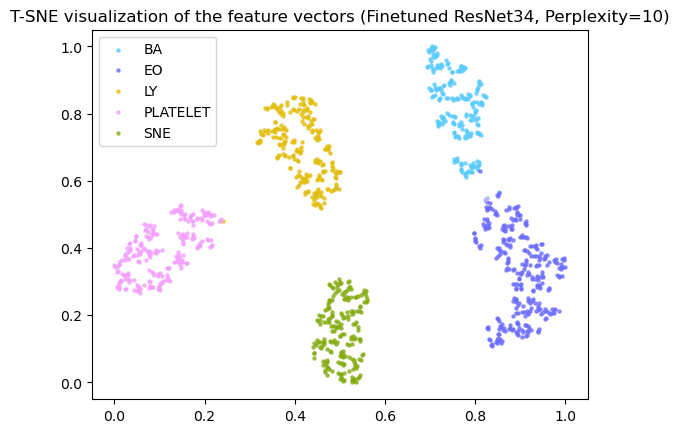

In [19]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = X_2d[:, 0]
ty = X_2d[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
 
# for every class, we'll add a scatter plot separately
for label in np.unique(labels):
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    # color = colors_per_class[label]
    color = np.array([colors_per_class[label][::-1]], dtype=np.float16) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=class_names[label], alpha=0.7, s=5)
    ax.title.set_text('T-SNE visualization of the feature vectors (Finetuned ResNet34, Perplexity=10)')
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot

## Visualization with Cell Images

In [20]:
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape
 
    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset
 
    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset
 
    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
 
    br_x = tl_x + image_width
    br_y = tl_y + image_height
 
    return tl_x, tl_y, br_x, br_y
 
def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image


def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color[::-1], thickness=5)

    return image

In [24]:
# we'll put the image centers in the central area of the plot
# and use offsets to make sure the images fit the plot
plot_size = 1000
max_image_size = 100
offset = max_image_size // 2
image_centers_area_size = plot_size - 2 * offset

# init the plot as white canvas
tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)
 
# now we'll put a small copy of every image to its corresponding T-SNE coordinate
i = 0
for image, label, x, y in tqdm.tqdm(
        zip(ii, labels, tx, ty),
        desc='Building the T-SNE plot',
        total=len(dataloaders['val'])
):
    image = image.transpose((1, 2, 0))
    # print(image.shape, label)
    # image = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    image = (image*255).astype(np.uint8)
 
    # scale the image to put it to the plot
    image = scale_image(image, max_image_size)
 
    # draw a rectangle with a color corresponding to the image class
    image = draw_rectangle_by_class(image, label)
 
    # compute the coordinates of the image on the scaled plot visualization
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)
 
    # put the image to its t-SNE coordinates using numpy sub-array indices
    tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
    i += 1
    if i > 500:
        break
 

Building the T-SNE plot: 500it [00:00, 2752.47it/s]            


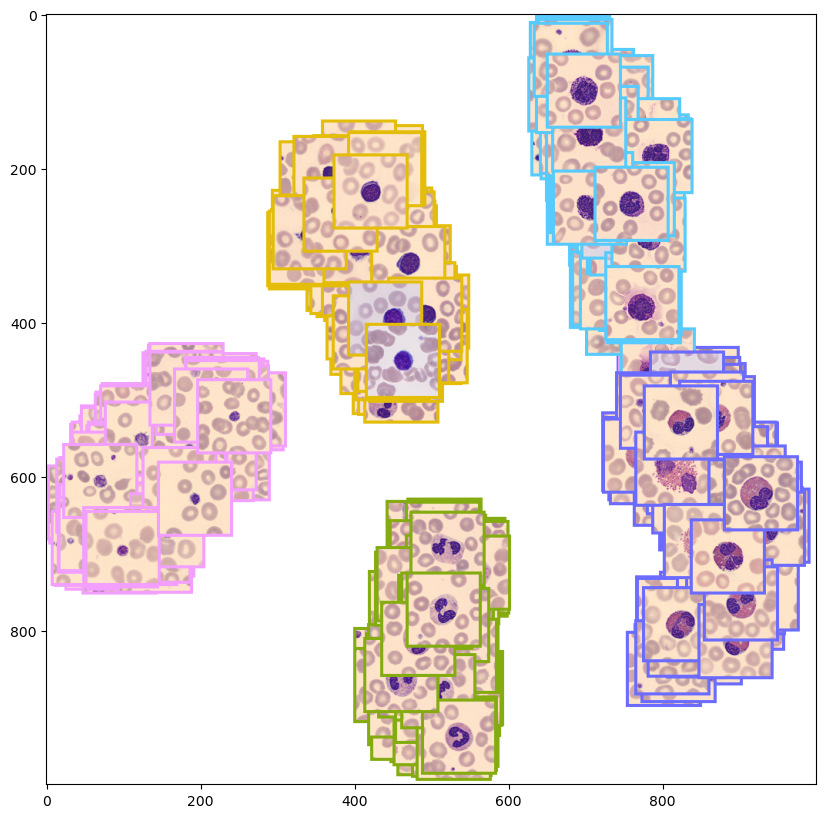

In [25]:
# plt.imshow(cv2.cvtColor(tsne_plot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(10, 10))
plt.imshow(tsne_plot)
plt.savefig("./visualizations/tsne_plot.pdf")
plt.show()

Building the T-SNE plot: 1000it [00:00, 2392.70it/s]           

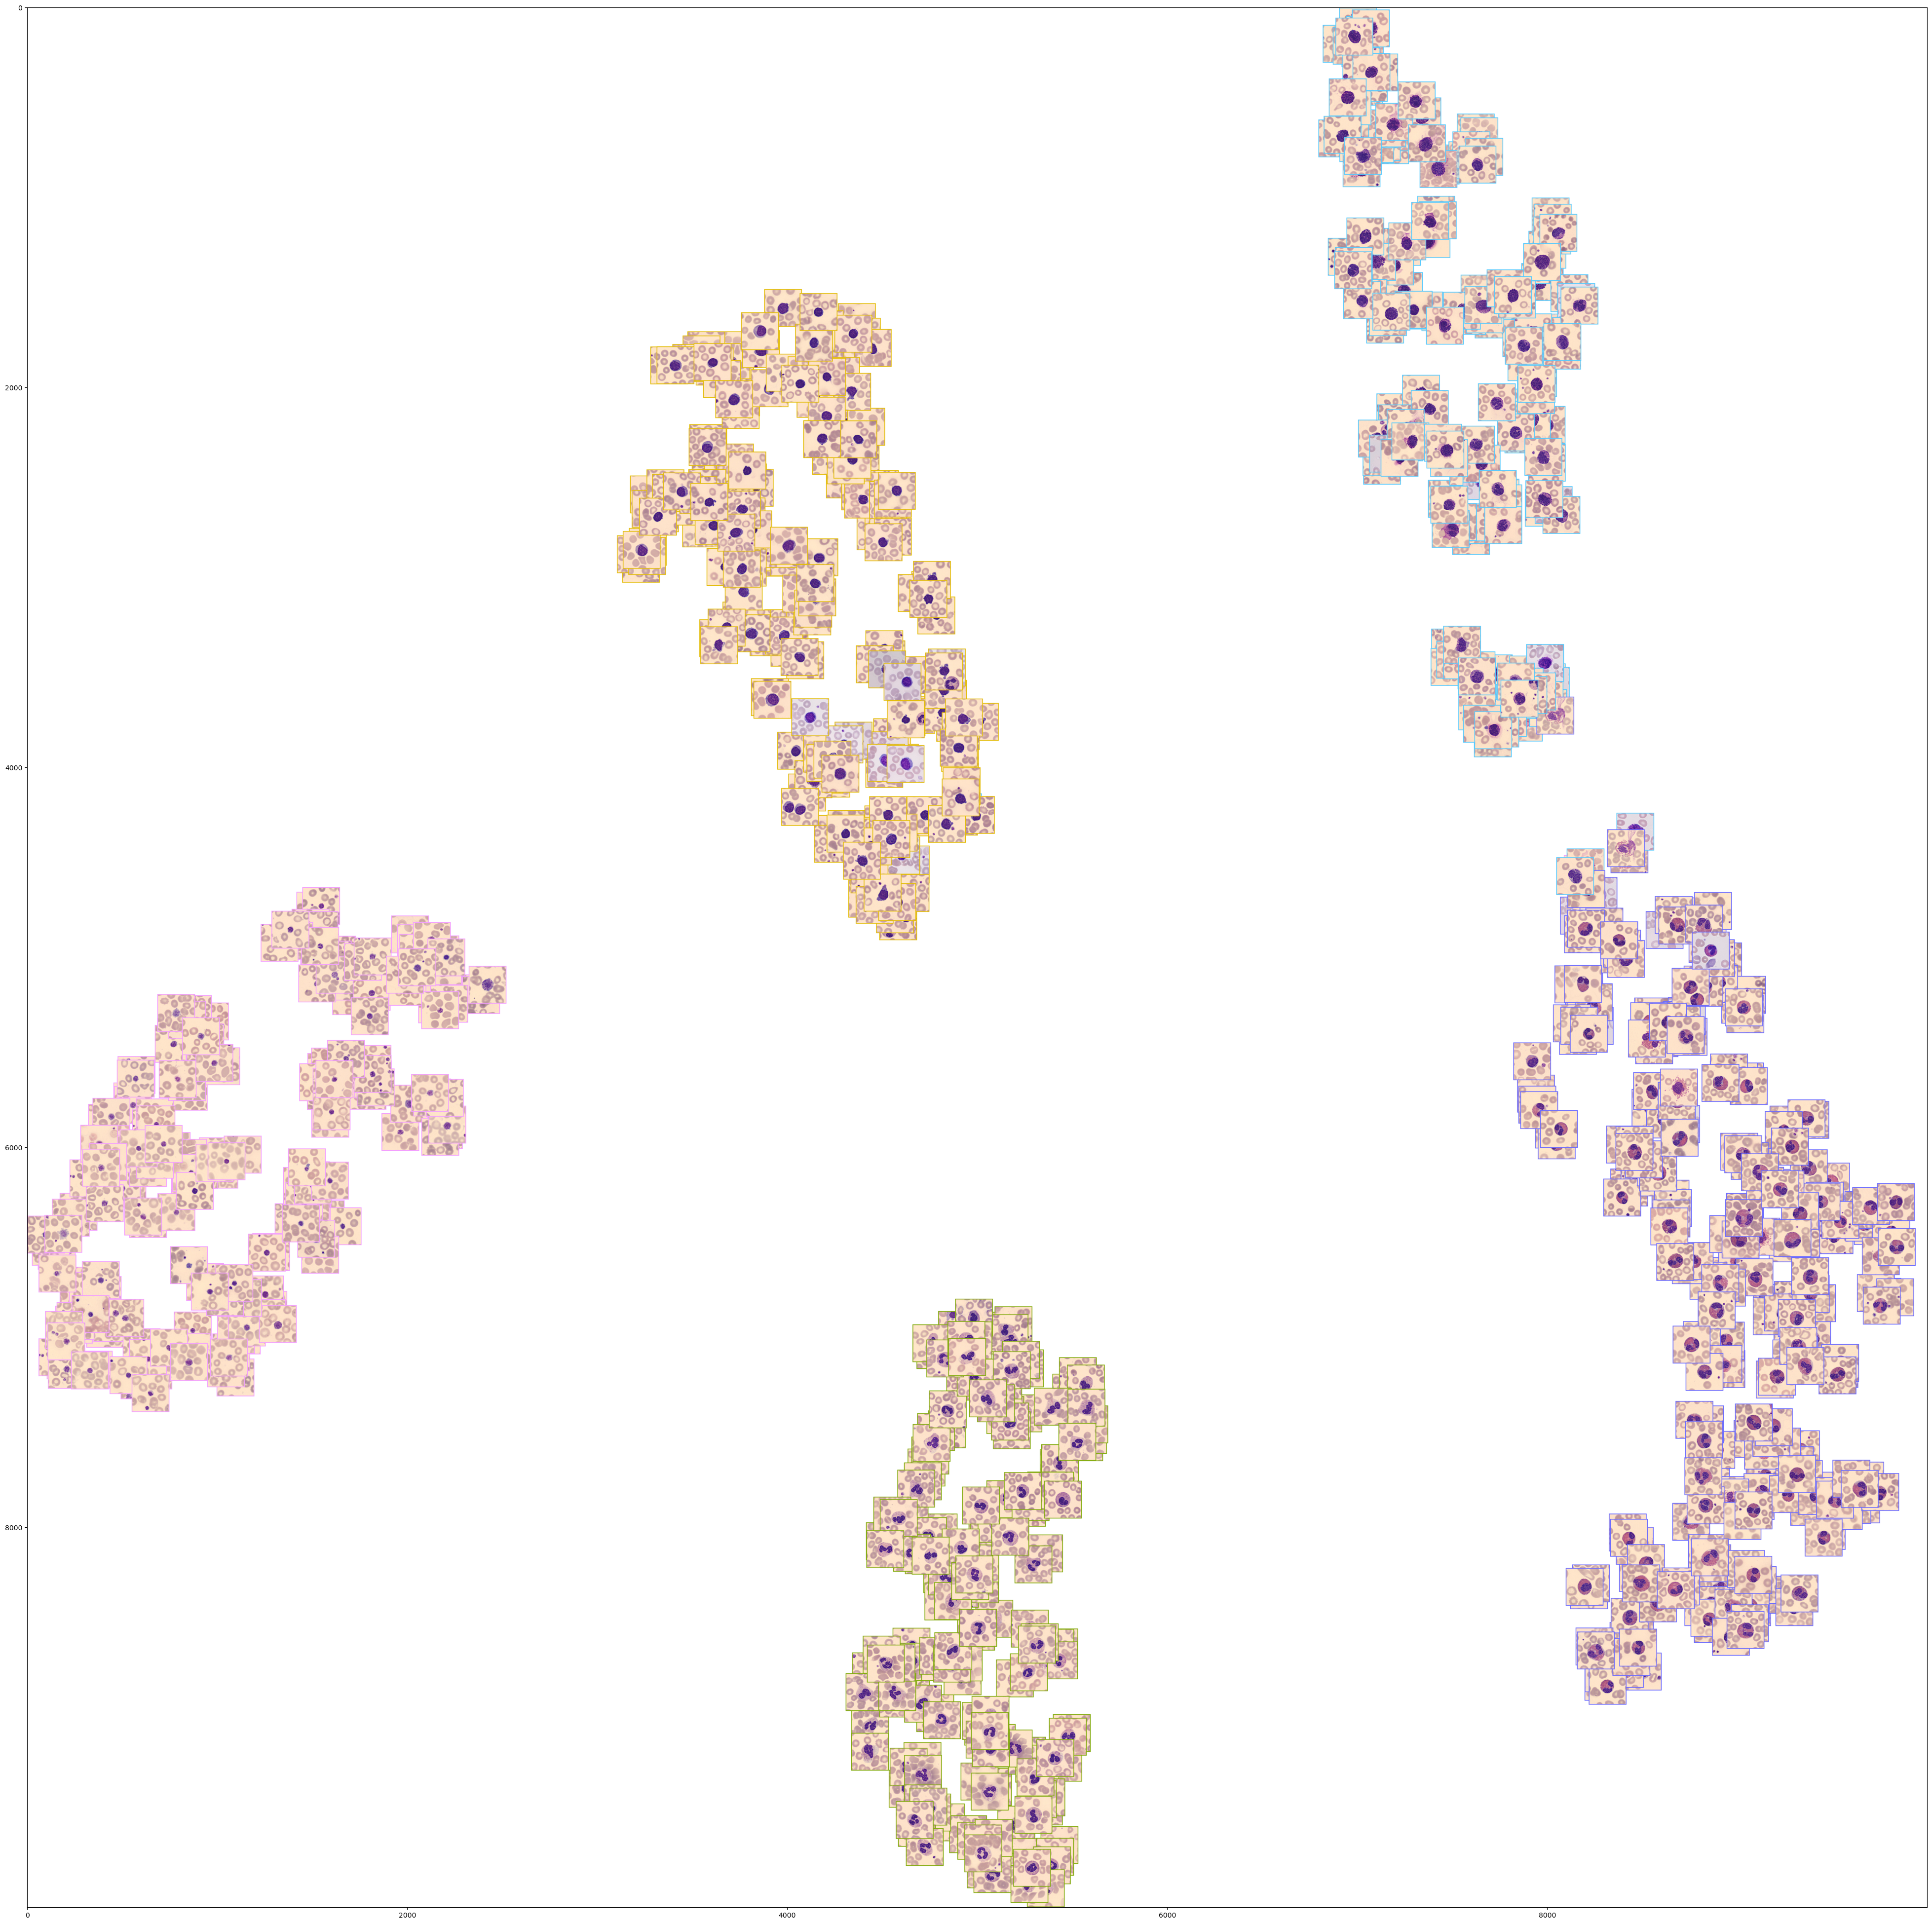

In [26]:
# we'll put the image centers in the central area of the plot
# and use offsets to make sure the images fit the plot
plot_size = 10000
max_image_size = 200
offset = max_image_size // 2
image_centers_area_size = plot_size - 2 * offset

# init the plot as white canvas
tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)
 
# now we'll put a small copy of every image to its corresponding T-SNE coordinate
i = 0
for image, label, x, y in tqdm.tqdm(
        zip(ii, labels, tx, ty),
        desc='Building the T-SNE plot',
        total=len(dataloaders['val'])
):
    image = image.transpose((1, 2, 0))
    # print(image.shape, label)
    # image = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    image = (image*255).astype(np.uint8)
 
    # scale the image to put it to the plot
    image = scale_image(image, max_image_size)
 
    # draw a rectangle with a color corresponding to the image class
    image = draw_rectangle_by_class(image, label)
 
    # compute the coordinates of the image on the scaled plot visualization
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)
 
    # put the image to its t-SNE coordinates using numpy sub-array indices
    tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
    i += 1
    if i > 1000:
        break

# plt.imshow(cv2.cvtColor(tsne_plot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(50, 50))
plt.imshow(tsne_plot)
plt.savefig("./visualizations/tsne_plot_large.pdf")

In [27]:
# # target_ids = range(labels)

# from matplotlib import pyplot as plt
# plt.figure(figsize=(6, 5))
# colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
# colors = colors[:len(np.unique(labels))]
# for i, c, label in zip(np.unique(labels), colors, np.unique(labels)):
#     plt.scatter(X_2d[labels == i, 0], X_2d[labels == i, 1], c=c, label=class_names[label], alpha=0.5, s=10)

# plt.legend()
# plt.show()